based off of https://github.com/scverse/scvi-tutorials/blob/main/scrna/scVI_DE_worm.ipynb

# Differential expression on C. elegans data

This notebook was contributed by Eduardo Beltrame [@Munfred](https://github.com/Munfred) and edited by Romain Lopez, Adam Gayoso, and Pierre Boyeau.

Processing and visualizing 89k cells from Packer et al. 2019 C. elegans 10xv2 single cell data

Original article:
`A lineage-resolved molecular atlas of C. elegans embryogenesis at single-cell resolution`

https://science.sciencemag.org/content/365/6459/eaax1971.long

The anndata object we provide  has 89,701 cells and 20,222 genes.
It includes short gene descriptions from [WormBase](https://wormbase.org) that will show up when mousing over the interactive plots.

**Steps performed**:

1. Loading the data from anndata containing cell labels and gene descriptions
1. Training the model with batch labels for integration with scVI
1. Retrieving the scVI latent space and imputed values
1. Visualize the latent space with an interactive t-SNE plot using Plotly
1. Perform differential expression and visualize with interactive volcano plot and heatmap using Plotly

This notebook was designed to be run in Google Colab.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [ ]:
import os
import tempfile
import torch.functional as F
from scvi.model import SCVI
from scvi.train import TrainingPlan
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import scanpy as sc
import seaborn as sns
import torch
import scvi
from pytorch_lightning.loggers import TensorBoardLogger
from datetime import datetime

# set pandas display options
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)

/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def select_gene_likelihood(adata):
    """
    Determines the appropriate gene likelihood distribution for the SCVI model 
    based on the properties of the input AnnData object.
    
    Parameters:
    - adata: AnnData object containing single-cell RNA-seq data.

    Returns:
    - str: Selected gene likelihood distribution ("nb", "zinb", "poisson").
    """
    
    # Check for zero-inflation by counting the proportion of zero values in the data
    zero_proportion = (adata.X == 0).sum() / adata.X.size
    
    # Select likelihood based on zero inflation and count properties
    if zero_proportion > 0.4:
        gene_likelihood = "zinb"  # Zero-Inflated Negative Binomial for high zero-inflation
    elif adata.X.mean() < 5:
        gene_likelihood = "poisson"  # Poisson for low-count data
    else:
        gene_likelihood = "nb"  # Negative Binomial for typical gene expression
    
    print(f"Selected gene likelihood: {gene_likelihood}")
    return gene_likelihood

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)    

Seed set to 0


Last run with scvi-tools version: 1.2.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [5]:
load_original_synthetic_data = False
if load_original_synthetic_data:
    adata_path = os.path.join(save_dir.name, "packer2019.h5ad")
    adata_path = '../starfysh_reproducibility/data/CID44971_TNBC/CID44971_TNBC/CID44971_TNBC.h5ad'

    adata = sc.read(
        adata_path,
        backup_url="https://github.com/Munfred/wormcells-site/releases/download/packer2019/packer2019.h5ad",
    )
    if 'CN' not in  adata.obs:
        adata.obs['CN'] = pd.Categorical(np.random.randint(0, 5, adata.shape[0]))
    CID44971_metadata = pd.read_csv('../starfysh_reproducibility/data/CID44971_TNBC/CID44971_TNBC/CID44971_metadata.csv')
    # metadata = pd.read_csv('../starfysh_reproducibility/data/CID44971_TNBC/CID44971_TNBC/scrna/metadata_sf.csv')


    nan_locs = CID44971_metadata['Classification'].isna()

    if nan_locs.sum()>0:
        CID44971_metadata = CID44971_metadata[~nan_locs]
        adata = adata[~nan_locs]
    adata.obs["cell_type"] = pd.Categorical(CID44971_metadata["Classification"].values)
else:
    adata_path = '../data/synthetics_adata_cn.h5ad'

    adata = sc.read(adata_path)
    adata.obs['CN'] = adata.obs['cn_vector_int'] 
    adata.obs['cell_type'] = adata.obs['celltype_major'] 
    

### Take a look at the gene descriptions

The gene descriptions were taken using the [WormBase API](https://wormbase.org/about/userguide/for_developers#3--10).

### Selecting genes and loading data

We use the utility `scvi.data.poisson_gene_selection` to select genes according to their dropout rate, which is a simple and scalable approach to select genes.

This method was described by Andrews & Hemberg in the article `M3Drop: dropout-based feature selection for scRNASeq `:
https://academic.oup.com/bioinformatics/article/35/16/2865/5258099

This method modifies the adata to add the following fields:

```
highly_variable                   # boolean true for chosen genes
observed_fraction_zeros	       # fraction of observed zeros per gene
expected_fraction_zeros	       # expected fraction of observed zeros per gene
prob_zero_enriched_nbatches	   # If batch_key is given, this denotes in how many batches genes are detected as zero enriched
prob_zero_enrichment	          # Probability of zero enrichment, median across batches in the case of multiple batches
prob_zero_enrichment_rank         # Rank of the gene according to probability of zero enrichment
```

```{note}
Gene selection is an important step to obtain relevant cell representations with scVI.
Generally, selecting the top few thousands top-ranking genes predicted by a gene selection tool suffice to obtain good performance.

Increasing the number of selected genes may be required in some applications, e.g., to increase the number of considered genes for differential expression.
Note, however, that this will increase the time required to reach convergence and GPU memory load.
It may also require to tune scVI's model hyperparameters (see the autotune tutorial)

Alternatives to the Poisson gene selection can be used, e.g., via scanpy or seurat.
```

In [6]:
cn_profiles_dict = { # T Cells
                (1, 1, 0, 0, 0, 0, 0, 0, 0) : 1, # Activated CD8, Plasmoblasts
                (1 ,0, 1, 0, 0, 0, 0, 0, 0) : 2, # Tcm, PVL immature
                (1, 0, 0, 1, 0, 0, 0, 0, 0) : 3, # Treg, normal epithelial
                (1, 0, 0, 0, 1, 0, 0, 0, 0) : 4, # Tem, pdC
                (1, 0, 0, 0, 0, 1, 0, 0, 0) : 5, # Tfh, endothelial
                # skip plasmoblasts, as can also use the T-cell activated CD8
                # PVL
                (0 ,0, 1, 0, 0, 0, 1, 0, 0) : 6, # PVL differentiated, cancer_epithelial_basal
                # skip normal epithelial, can just use Treg
                # myeloid has a lot of subtypes
                (0, 0, 0, 0, 1, 0, 0, 1, 0) : 7, # cDC , CAFs myCAF-like
                (0, 0, 0, 0, 1, 0, 0, 0, 1) : 8, # Macrophage M1, B cells memory
                (0, 1, 0, 0, 1, 0, 0, 0, 0) : 9, # Monocytes, assigned to random plasmablast
                (0, 0, 1, 0, 1, 0, 0, 0, 0) : 10, # Macrophage M2, assigned to random PVL
                # skip Endothelial
                # cancer epithelial
                (0, 0, 0, 1, 0, 0, 1, 0, 0) : 11, # LumB, assigned to random normal epithelial
                # skip CAFs
                # B-cells
                (0, 0, 0, 0, 0, 1, 0, 0, 1) : 12, # B cells naive
            }
# reverse the dictionary
cn_profiles_dict = {v: k for k, v in cn_profiles_dict.items()}
adata.uns['cn_profiles_dict'] = cn_profiles_dict



In [7]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)
# poisson_gene_selection = scvi.data.poisson_gene_selection(adata)

adata.var.head()


,n_counts
0,4.0
1,3.0
2,515.0
3,69.0
4,6.0


In [8]:
adata.var.head()


,n_counts
0,4.0
1,3.0
2,515.0
3,69.0
4,6.0


In [9]:
if 'highly_variable' in adata.var:
    
    adata = adata[:, adata.var["highly_variable"]]  # focus on selected genes
adata.layers["counts"] = adata.X.copy().tocsr()  # converts to CSR format, preserve counts
adata.obs["cell_type"].value_counts()
# select only one cell type
# adata = adata[adata.obs["cell_type"] == "DCIS"].copy()
# add adata.obs['cn_vector_int']  to the categorical covariates 
SCVI.setup_anndata(
    adata, 
    labels_key="CN",                # Use CN as label information
    categorical_covariate_keys=["cell_type"] , # Register cell types as a covariate
    # obsm_key="cn_vector"
)
print('new shape is:', adata.shape)


new shape is: (5335, 19349)


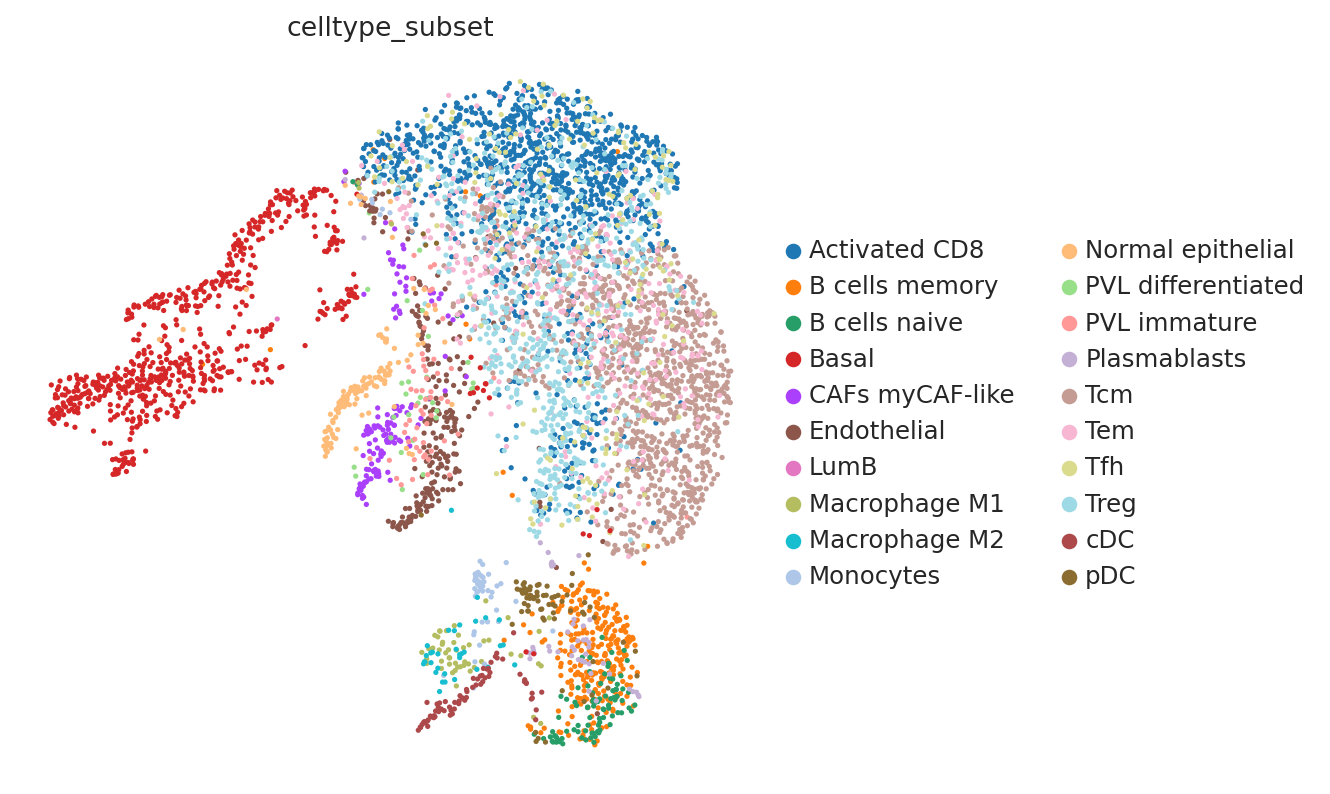

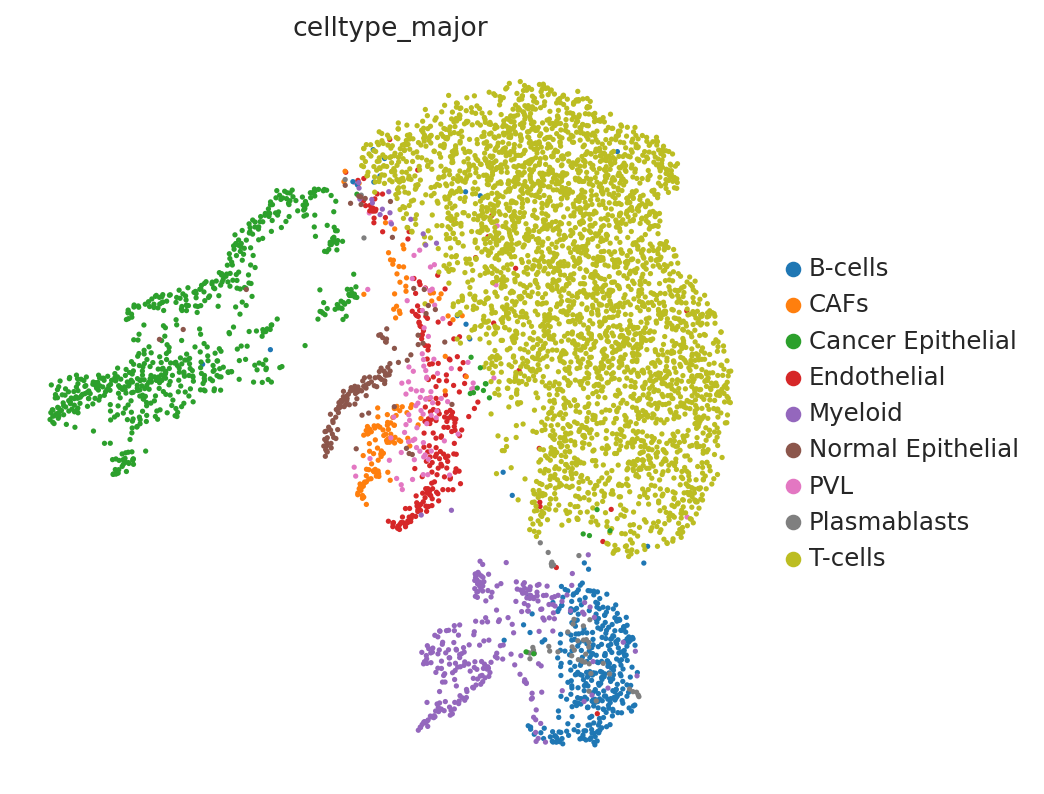

In [ ]:
sc.pp.neighbors(adata,key_added='original_neighbors')
sc.tl.umap(adata,neighbors_key='original_neighbors')
sc.pl.umap(adata, color="celltype_subset",neighbors_key='original_neighbors',title='Original data')
sc.pl.umap(adata, color="celltype_major",neighbors_key='original_neighbors',title='Original data')


### Define and train the model

In [ ]:
class CNTrainingPlan(TrainingPlan):
    def __init__(self, module, **kwargs):
        super().__init__(module, **kwargs)

    def training_step(self, batch, batch_idx):
        # Call the base training step for standard loss computation
        base_loss = super().training_step(batch, batch_idx)

        # Access the labels for contrastive loss
        # cell_type_info = batch["labels"].squeeze()  # Or use 'extra_categorical_covs' if appropriate
        extra_categorical_covs = batch["extra_categorical_covs"].squeeze() 
        major_cell_type = extra_categorical_covs[:]
        cell_neighborhood_info = batch["labels"].squeeze() 
        # cell_type_info = cell_type_info.cpu().numpy()
        # cn_category = torch.tensor([adata.uns['cn_profiles_dict'][i+1] for i in cell_type_info[:,1]])

        # cn_category = torch.tensor([adata.uns['cn_profiles_dict'][i] for i in cell_type_info[:,0]])
        # Get latent embeddings from the encoder
        inference_outputs = self.module.inference(
            batch["X"], batch_index=batch["batch"], n_samples=1
        )
        latent_embeddings = inference_outputs["z"].squeeze(0)  # Shape: (num_cells, latent_dim)

        # Compute pairwise distances
        distances = torch.cdist(latent_embeddings, latent_embeddings, p=2)

        # Exclude self-pairs
        num_cells = cell_neighborhood_info.shape[0]
        diagonal_mask = torch.eye(num_cells, dtype=torch.bool, device=cell_neighborhood_info.device)
        # this will give us each row represents a item in the array, and each col is whether it is the same as the items in that index of the col
        # this way we get for each cell(a row) which other cells (index of each item in the row, which is the col) are matching
        # so if we got 1,2,1, we will get [[1,0,1],[0,1,0],[1,0,1]]
        same_cn_mask = cell_neighborhood_info.unsqueeze(0) == cell_neighborhood_info.unsqueeze(1)
        same_major_cell_type  = major_cell_type.unsqueeze(0) == major_cell_type.unsqueeze(1)
    
        if batch["batch"][0].item()==0: # show the mask only for the first batch to make sure it is working as expected
            plt.imshow(same_cn_mask.cpu().numpy())
        distances = distances.masked_fill(diagonal_mask, 0) 

        same_major_type_same_cn_mask = (same_major_cell_type * same_cn_mask).type(torch.bool)
        same_major_type_different_cn_mask = (same_major_cell_type * ~same_cn_mask).type(torch.bool)
        different_major_type_same_cn_mask = (~same_major_cell_type * same_cn_mask).type(torch.bool)
        different_major_type_different_cn_mask = (~same_major_cell_type * ~same_cn_mask).type(torch.bool)
        
        same_major_type_same_cn_mask.masked_fill_(diagonal_mask, 0)
        same_major_type_different_cn_mask.masked_fill_(diagonal_mask, 0)
        different_major_type_same_cn_mask.masked_fill_(diagonal_mask, 0)
        different_major_type_different_cn_mask.masked_fill_(diagonal_mask, 0)
        
        same_major_type_same_cn_loss = (distances ** 2) * same_major_type_same_cn_mask
        same_major_type_different_cn_loss = ((1 - distances).clamp(min=0) ** 2)* same_major_type_different_cn_mask
        different_major_type_same_cn_loss = ((1 - distances).clamp(min=0) ** 2)* different_major_type_same_cn_mask
        different_major_type_different_cn_loss = ((1 - distances).clamp(min=0) ** 2) * different_major_type_different_cn_mask
        # for debugging only: # todo remove this same_cn_loss, it is not valid
        same_cn_loss = (distances ** 2)*same_cn_mask 
        same_major_type_loss = (distances ** 2)*same_major_cell_type
        # end of debugging
        
        positive_loss =  same_major_type_same_cn_loss
        
        # TODO change to temperature, learnable?
        negative_loss = different_major_type_different_cn_loss + different_major_type_same_cn_loss + 2*same_major_type_different_cn_loss   
        cn_loss = (positive_loss.sum() + negative_loss.sum()) / (num_cells * (num_cells - 1))

        # Combine losses
        total_loss = base_loss + 1 * cn_loss

        # Log losses
        self.log("train_base_loss", base_loss, prog_bar=True)
        self.log("train_cn_loss", cn_loss, prog_bar=True)

        return total_loss

model = scvi.model.SCVI(
    adata, gene_likelihood=select_gene_likelihood(adata),
    n_layers=2 ,n_latent=10, n_hidden=128,
)  


model._training_plan_cls = CNTrainingPlan # CRUCIAL: Set the training plan to the custom class

/tmp/ipykernel_9908/1084902730.py:79: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.


Selected gene likelihood: zinb


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [01:46<00:00,  1.06s/it, v_num=1, train_loss_step=4.29e+3, train_base_loss=4.29e+3, train_cn_loss=0.633, train_loss_epoch=4.66e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [01:46<00:00,  1.07s/it, v_num=1, train_loss_step=4.29e+3, train_base_loss=4.29e+3, train_cn_loss=0.633, train_loss_epoch=4.66e+3]


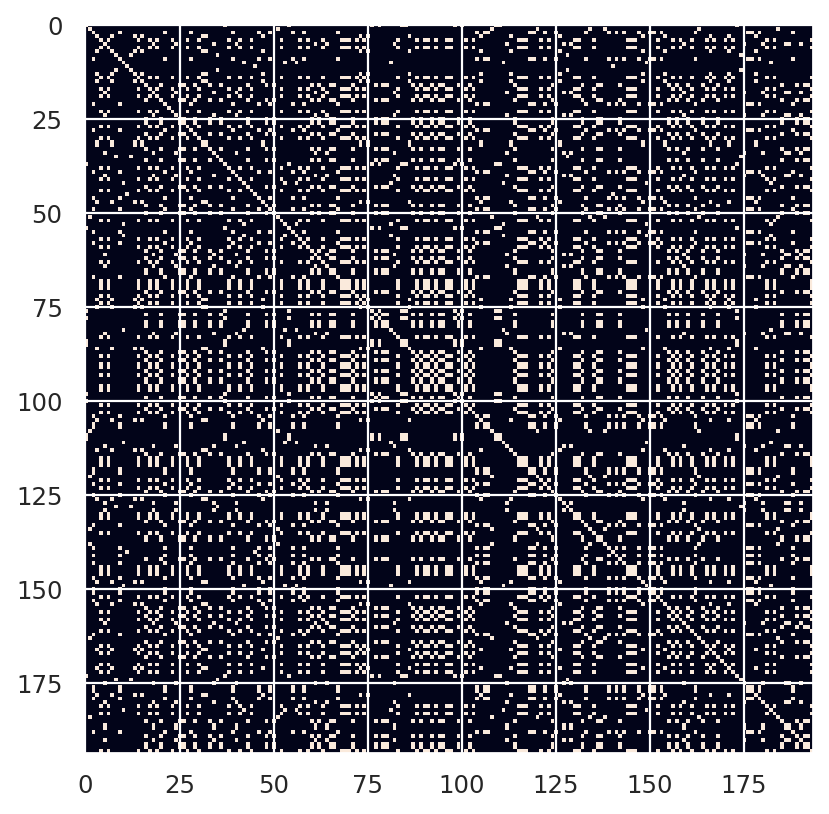

In [12]:
experiment_name =  datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
logger = TensorBoardLogger("tb_logs", name=experiment_name)

model.train(
    check_val_every_n_epoch=1,
    max_epochs=100,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
    batch_size= 256,
    # logger=logger,  
)

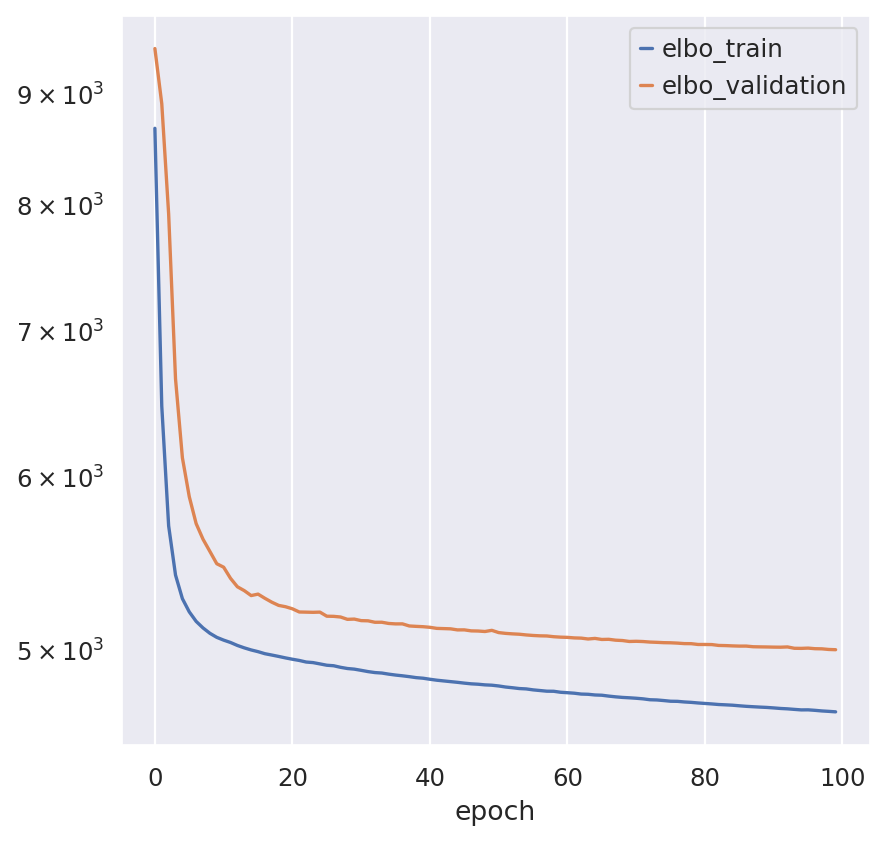

In [13]:
# Ensure convergence
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[:].plot(logy=True)  # exclude first 10 epochs
plt.show()

### Get the latent space and compute UMAP

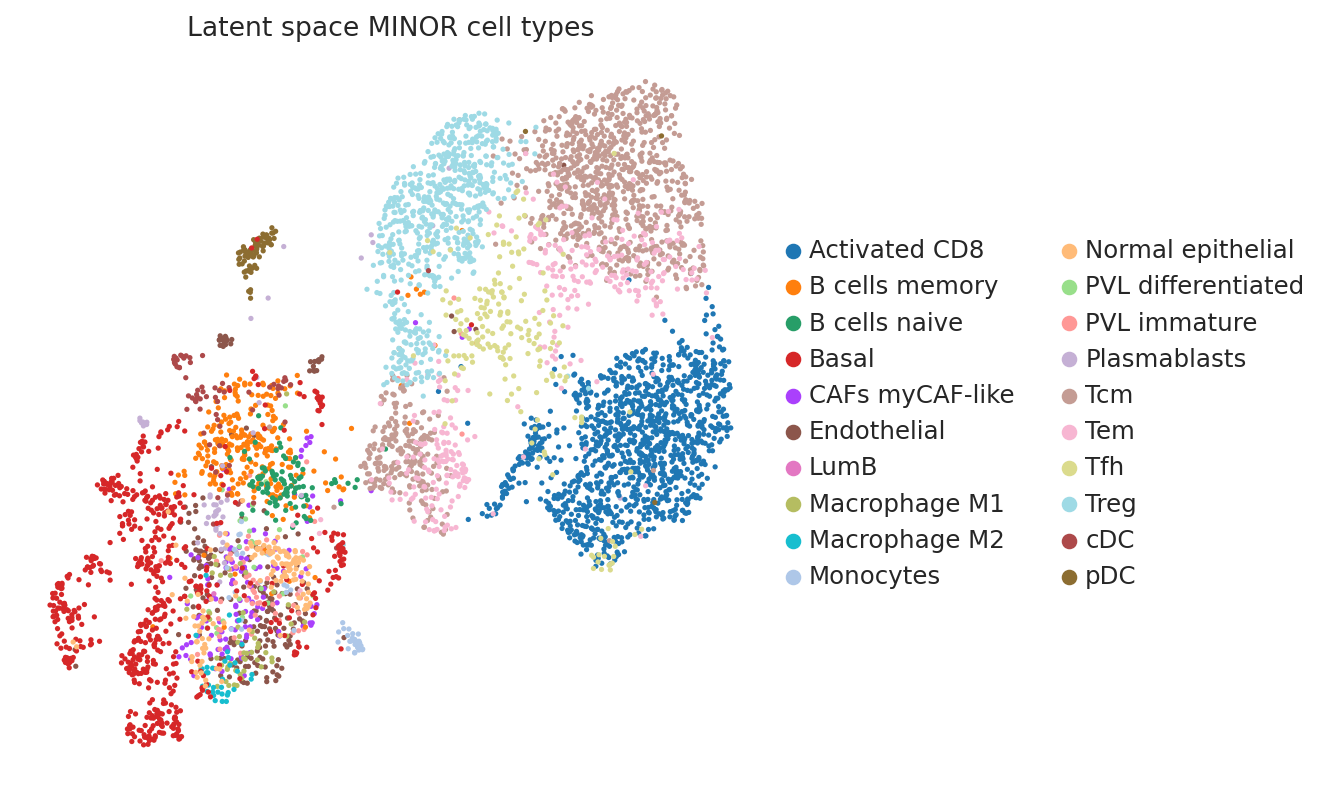

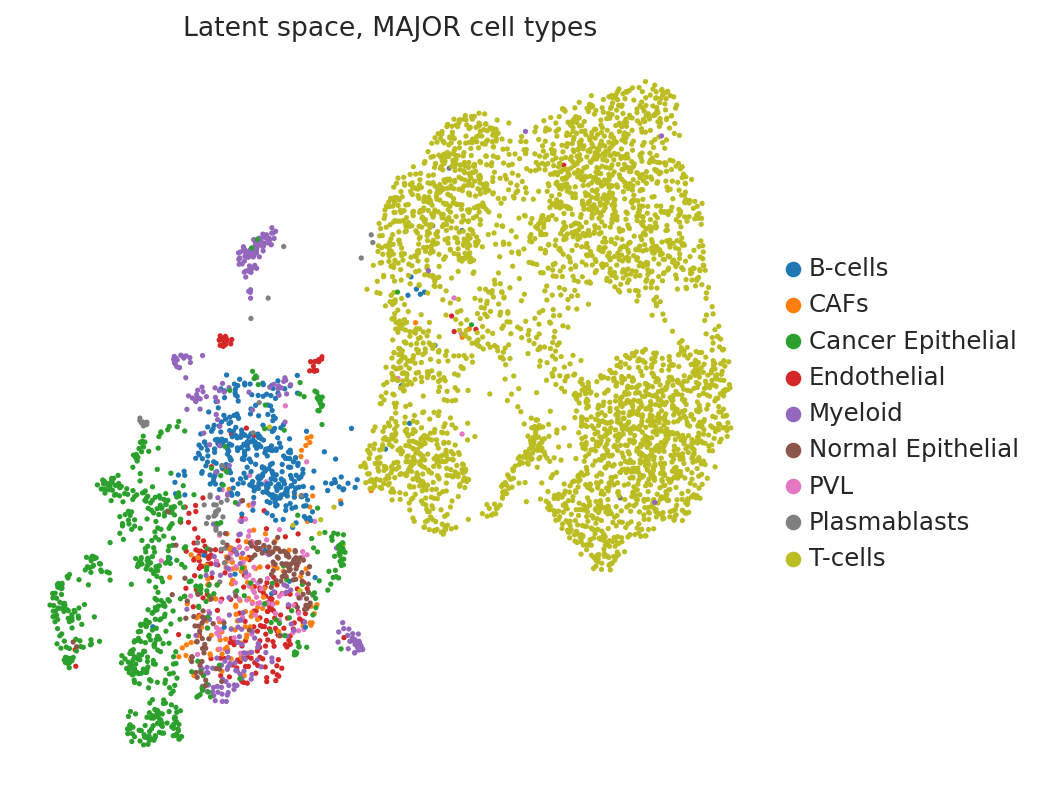

In [23]:
SCVI_LATENT_KEY = "X_scVI"
latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent

sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY,key_added='latent_space_neighbors')
sc.tl.umap(adata,neighbors_key='latent_space_neighbors')

sc.pl.umap(adata, color="celltype_subset",neighbors_key='latent_space_neighbors',title='Latent space MINOR cell types')
sc.pl.umap(adata, color="celltype_major",neighbors_key='latent_space_neighbors',title='Latent space, MAJOR cell types')

In [15]:
# adata.write("synthetic_data_with_latent_space.h5ad"            )
adata.uns = {str(k): v for k, v in adata.uns.items()}
import json
if 'cn_profiles_dict' in adata.uns:
    adata.uns['cn_profiles_dict'] = json.dumps(adata.uns['cn_profiles_dict'])

adata.write("symthetic_rna_with_latent_space.h5ad")

In [27]:
from sklearn.metrics import silhouette_score

# latent_embeddings are the low-dimensional embeddings for each cell
# silhouette_avg_orig = silhouette_score(adata.X, adata.obs['cell_type'])
# silhouette_avg_latent = silhouette_score(latent, adata.obs['cell_type'])
# print(f"Original silhouette score: {silhouette_avg_orig}")
# print(f"Latent silhouette score: {silhouette_avg_latent}")

silhouette_score_per_cell_type_original = {}
silhouette_score_per_cell_type_latent = {}
cell_types = set(adata.obs['cell_type'])
latent = adata.obsm[SCVI_LATENT_KEY]
# rna_embedding.obs['silhouette_score']  = [None]*rna_embedding.obs.shape[0]

for curr_cell_type in cell_types:
    
    curr_cell_type_indexes = adata.obs['cell_type'] == curr_cell_type
    curr_cell_type_data = adata[curr_cell_type_indexes].X
    curr_predicted_CN =  adata[curr_cell_type_indexes].obs['CN']
    curr_latent = latent[curr_cell_type_indexes]
    try:
        silhouette_score_per_cell_type_original[curr_cell_type] = silhouette_score(curr_cell_type_data, curr_predicted_CN)
        silhouette_score_per_cell_type_latent[curr_cell_type] = silhouette_score(curr_latent, curr_predicted_CN)
    except:
        pass
    # adata.obs['silhouette_score'][curr_cell_type_indexes] = silhouette_score_per_cell_type[curr_cell_type]

# print(f"Original silhouette score: {silhouette_score_per_cell_type_original}")
# print(f"Latent silhouette score: {silhouette_score_per_cell_type_latent}")
# print(f'overall improvement in silhouette score: {np.mean(list(silhouette_score_per_cell_type_latent.values())) - np.mean(list(silhouette_score_per_cell_type_original.values()) )}')

# dont just do the mean make it weighted by the number of cells in each cell type
weighted_avg_original = np.mean([silhouette_score_per_cell_type_original[k]*v for k,v in adata.obs['cell_type'].value_counts().items() if k in  silhouette_score_per_cell_type_original])/adata.obs.shape[0]
weighted_avg_latent = np.mean([silhouette_score_per_cell_type_latent[k]*v for k,v in adata.obs['cell_type'].value_counts().items() if k in  silhouette_score_per_cell_type_latent])/adata.obs.shape[0]
# show improvement in silhouette score
print(f"Original silhouette score: {weighted_avg_original}")
print(f"Latent silhouette score: {weighted_avg_latent}")
print(f'overall improvement in silhouette score: {weighted_avg_latent - weighted_avg_original}')

Original silhouette score: -0.002614669256818314
Latent silhouette score: 0.0189895887172348
overall improvement in silhouette score: 0.021604257974053114


## Performing Differential Expression in scVI

Differential expression (DE) analysis is used to quantify the differences in gene expression across subpopulations of genes.
If we have two sets of cells $A$ and $B$, a DE test is typically used to predict two things for each gene:

1. Whether the gene's expression levels are significantly different in the A and B sets of cells.
1. An effect size that quantifies the strength of the differential expression.

Once trained, scVI can natively perform both of these tasks.
Additionally, its differential expression module can account for batch effects and filter DE genes expected to be of little relevance.

### Selecting cell subpopulations to compare

In [17]:
# let's take a look at abundances of different cell types
adata.obs["cell_type"].value_counts()

cell_type
T-cells              3426
Cancer Epithelial     647
B-cells               369
Myeloid               282
Endothelial           217
CAFs                  131
Normal Epithelial     124
PVL                    91
Plasmablasts           48
Name: count, dtype: int64

scVI provides several options to identify the two populations of interest.

In [18]:
cell_type_1 = "DCIS"
cell_idx1 = adata.obs["cell_type"] == cell_type_1
print(sum(cell_idx1), "cells of type", cell_type_1)

cell_type_2 = "Stroma"
cell_idx2 = adata.obs["cell_type"] == cell_type_2
print(sum(cell_idx2), "cells of type", cell_type_2)

# or equivalently, provide a string of the form "my_celltype_column == 'desired_celltype'"
# cell_idx1 = "cell_type == 'Ciliated_non_amphid_neuron'"
# cell_idx2 = "cell_type == 'Intestine'"

0 cells of type DCIS
0 cells of type Stroma


### Basic principle

#### DE and log fold-changes

scVI can natively be used to perform differential expression analyses to compare populations of cells, as described [here](https://doi.org/10.1101/794289) and [there](https://doi.org/10.1101/2022.05.27.493625).
It achieves this by estimating the posterior distribution of the log fold-change (LFC) between subpopulations $A$ and $B$.
Specifically, for a given gene g, scVI calculates the LFC as the difference between the logarithm of its expression level in population A, denoted by $h_g^A$, and the logarithm of its expression level in population B, denoted by $h_g^B$.

The resulting value, denoted by $\beta_g$, provides insights into the expression patterns of gene $g$.
Values close to zero indicate that the gene is expressed similarly in both populations, positive values suggest upregulation in population A and negative values indicate downregulation in population A. This information can be used to better understand the biological mechanisms underlying the differences between the two cell populations.

#### DE testing

In addition to estimating the LFC, scVI can also detect which genes have *significant* expression patterns.
To tag which genes are differentially expressed, scVI tests the following competing hypotheses
$M_{1, g}: \beta_g \in [-\delta, \delta]$ and $M_{2, g}: \beta_g \in (-\infty, -\delta) \cup (\delta, \infty)$.
Here, $\delta$ denotes a small LFC threshold, such that $\beta_g \in [-\delta, \delta]$ is evidence that the gene is equally expressed in the two subpopulations.

Differentially expressed genes are identified by computing the posterior probability of $M_{2, g}$.

### Running DE analyses

#### Running and understanding a DE run

A simple DE analysis can then be performed using the following command

In [19]:
de_change = model.differential_expression(idx1=cell_idx1, idx2=cell_idx2)
de_change

ValueError: One of idx1 or idx2 has size zero.

This method returns a pandas DataFrame, where each row corresponds to a gene.
The most important columns of this dataframe are the following.
**proba_de**, which captures the posterior probability of $M_{2, g}$ that the gene is differentially expressed. Values close to one indicate that the gene is DE;
**lfc_mean** and **lfc_median**, respectively denoting the mean and the median of the posterior distribution of $\beta_g$. Positive values of the LFC signify that the gene is upregulated in `idx1`;
**is_de_fdr_0.05** is `True` when the gene is tagged DE after FDR correction at target level $\alpha=0.05$. The target level can be adjusted by specifying `fdr_target` in the `differential_expression` method.

#### Main hyperparameters

Additional parameters can be tuned in specific applications.

1. **weights**, which can correspond to <span style="color:#eb5e34">"uniform"</span> or <span style="color:#eb5e34">"importance"</span> specify how normalized gene expressions in the two subpopulations are computed. The <span style="color:#eb5e34">"importance"</span> flavor is specifically designed to provide FDR-calibrated gene sets, but may be overkill if you only aim to rank genes (via their LFC for instance).
1. **filter_outlier_cells** filters out outlier cells prior to computing normalized gene expressions. It is important to set this parameter to `True` when `weights='importance'`.
1. **delta** allows to specify $\delta$, which is used to detect differentially expressed genes. It can also be set automatically using `delta=None`
1. **pseudocounts**, which is zero by default, but can be set to a small value (e.g., 1e-6) when many detected DE genes are seldom expressed in the compared populations.
1. **batch_correction**, which should be set to `True` to account for batch effects. This only makes sense when `idx1` and `idx2` denote cells coming from overlapping batches.

The exact function of these parameters is described [here](https://doi.org/10.1101/2022.05.27.493625).

### Volcano plot of change mode DE with p-values

In [ ]:
de_change_uniform = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="uniform",
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_uniform["log10_pscore"] = np.log10(de_change_uniform["proba_not_de"])
de_change_uniform = de_change_uniform.join(adata.var, how="inner")
de_change_uniform.head()

DE...: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,...,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank
12093,0.8998,0.1002,2.195004,0.000987,0.000473,...,0.381034,0.141369,1,0.3205,18225.0
10693,0.8980,0.1020,2.175197,0.000985,0.000481,...,0.311207,0.218285,1,0.2455,16066.0
256,0.8970,0.1030,2.164327,0.001020,0.000509,...,0.282759,0.218999,1,0.2251,14601.0
16115,0.8942,0.1058,2.134379,0.001069,0.000523,...,0.292241,0.208828,1,0.2292,14849.0
18253,0.8918,0.1082,2.109260,0.000110,0.000208,...,0.665517,0.661135,1,0.2228,14476.0


In [ ]:
import torch
torch.cuda.empty_cache()

de_change_importance = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="importance",
    filter_outlier_cells=True,
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_importance["log10_pscore"] = np.log10(de_change_importance["proba_not_de"])
de_change_importance = de_change_importance.join(adata.var, how="inner")

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-399.583620107122670 > -405.609465147493665). You may want to try with a higher value of support_fraction (current value: 0.593).
/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-399.640686477612633 > -405.759067227080322). You may want to try with a higher value of support_fraction (current value: 0.593).
/home/barroz/miniconda3/envs/scvi_cuda/lib/python3.10/site-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-397.411311582672624 > -405.933646807949742). You may want to try with a higher value of support_fraction (

DE...:   0%|          | 0/1 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 490.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 372.69 MiB is free. Including non-PyTorch memory, this process has 3.44 GiB memory in use. Of the allocated memory 3.26 GiB is allocated by PyTorch, and 108.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
de_comp = pd.concat(
    [
        de_change_importance.assign(flavor="importance"),
        de_change_uniform.assign(flavor="uniform"),
    ]
)
de_comp["gene_type"] = "Other"
de_comp.loc[lambda x: x["gene_name"].str.contains("rpl-"), "gene_type"] = "RPL"
de_comp.loc[lambda x: x["gene_name"].str.contains("ceh-"), "gene_type"] = "CEH"
de_comp.loc[lambda x: x["gene_name"].str.contains("flp-"), "gene_type"] = "FPL"

(
    p9.ggplot(de_comp, p9.aes("lfc_mean", "-log10_pscore", color="gene_type"))
    + p9.geom_point(
        de_comp.query("gene_type == 'Other'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.geom_point(de_comp.query("gene_type != 'Other'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    + p9.facet_wrap("flavor")
)

KeyError: 'gene_name'

Contrary to the `uniform` flavor, the `importance` flavor returns sharper posterior probability scores (posterior probability near 0 or 1, respectively in case of equal expression or differential expression).

### Heatmap of top expressed genes

Now we perform DE between each cell type vs all other cells and make a heatmap of the result.

In [ ]:
# here we do a 1-vs-all DE test, which compares each cell type with all others
# this returns the concatenation of all 1vsall results, contained in a DataFrame
change_per_cluster_de = model.differential_expression(groupby="cell_type")

DE...:   0%|          | 0/37 [00:00<?, ?it/s]

We focus on cell-types with at least 500 cells, and which have annotations to facilitate heatmap visualization

In [ ]:
cell_types = (
    adata.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [ ]:
# This cell extracts list of top 5 upregulated genes for every cell-type
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)["index"]
    .unique()
)

/tmp/ipykernel_154/3695070939.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


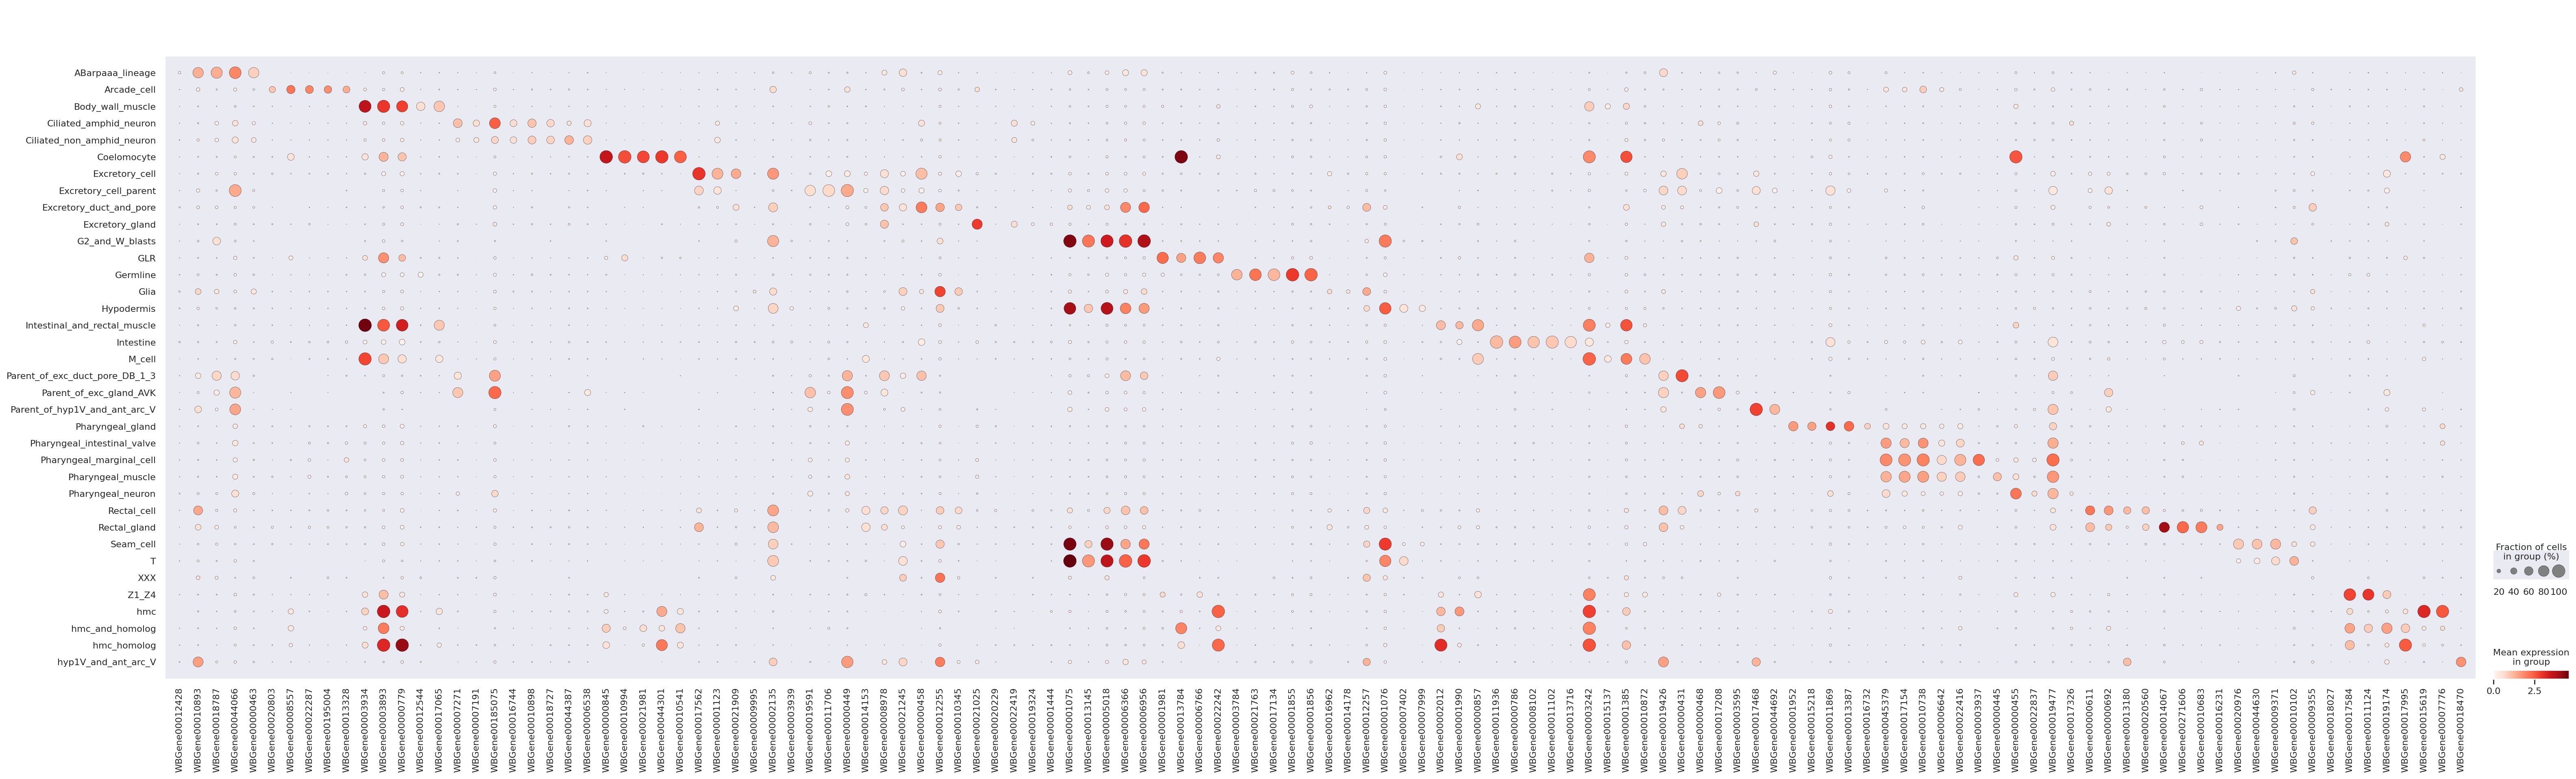

In [ ]:
adata_log = adata[adata.obs.cell_type.isin(cell_types.index.values)].copy()
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)
sc.pl.dotplot(adata_log, marker_genes, groupby="cell_type")